In [3]:
import sys
import os
import requests
import numpy as np
import scipy
from scipy.ndimage import uniform_filter
import pandas as pd
import matplotlib.pyplot as plt
import copy

import pynumdiff

In [51]:
try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

In [4]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
generate_training_data_utility = import_local_or_github('generate_training_data_utility', directory='../Utility')
terrain_and_optic_flow_utility = import_local_or_github('terrain_and_optic_flow_utility', directory='../Utility')

/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


# Download and load the optic flow data

This is a subset of all the trajectories we generated in a prior notebook. 

In [81]:
generate_training_data_utility.download_data('planar_drone_trajectories_opticflow_subset.zip')

keyword = 'opticflows'
optic_flows = generate_training_data_utility.load_trajectory_data(directory, keyword)

Fetching from: https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Data/planar_drone_trajectories_opticflow_subset.zip
Successfully downloaded planar_drone_trajectories_opticflow_subset.zip (89339606 bytes)
unzipping...
Number of trajectories: 
300


### Training / Validation Set

Grab a portion for "training" the SVD. And a separate portion for validation. 

In [82]:
# Merge the training set into a single dataframe
training_set = pd.concat(optic_flows[0:90], axis=0)

# Keep the test sets as individual trajectories
test_set = optic_flows[90:]

# SVD Compression

MATH explanation of SVD goes here.

First, look at the shape of our training set. It has the rows as snapshots.

In [83]:
training_set.shape

(8100, 209)

Standard data format for this is to have the columns correspond to the snapshots of data, so we need to transpose relative to the dataframe which has rows being snapshots.

In [84]:
Omega = training_set.values.T
Omega.shape

(209, 8100)

Perform the SVD. 

In [85]:
U, E, Vt = np.linalg.svd(Omega, full_matrices=False)

## Now we truncate small singular values

This can be done either via an "optimal" approach, or manually. Either way, it is helpful to look at the distribution of singular values to get a sense of the rank underlying the data. 

### Option 1: Choose the cutoff $r$ optimally

See: https://ieeexplore.ieee.org/document/6846297

rank:  63


Text(0, 0.5, 'Value of singular value')

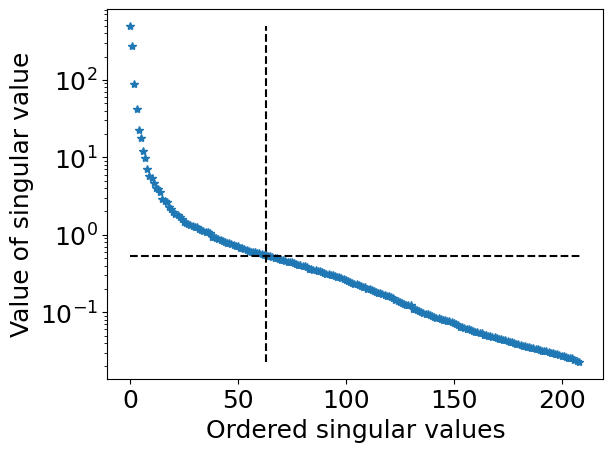

In [86]:
# optimal singular value cutoff
singvalthresh = 4/np.sqrt(3)*np.median(E)
r = np.where(E>singvalthresh)[0][-1]
print('rank: ', r)

plt.plot(E, '*')
plt.yscale('log')
plt.hlines(singvalthresh, 0, len(E), linestyles='--', color='black')
plt.vlines(r, np.min(E), np.max(E), linestyles='--', color='black')

plt.xlabel('Ordered singular values')
plt.ylabel('Value of singular value')

### Option 2: Choose $r$ manually (e.g. for more compression)

In [87]:
r = 20

### Truncate with choice of rank

In [88]:
Ur = U[:,0:r]
Er = np.diag(E[0:r])
Vr = Vt.T[:,0:r]

### Look at the modes

The columns of Ur show the basis. In principle each complete signal can be reconstructed from this basis set. Notice how in this case the basis set looks like a warped Fourier basis. The warping is because optic flow is more variable towards the edges of the field of view. 

The first two bases capture optic flow for flat terrain and horizontal and vertical movement. The other bases capture combinations of these flow patterns and provide the richness needed to model the terrain itself. 

Text(0, 0.5, 'Optic flow basis')

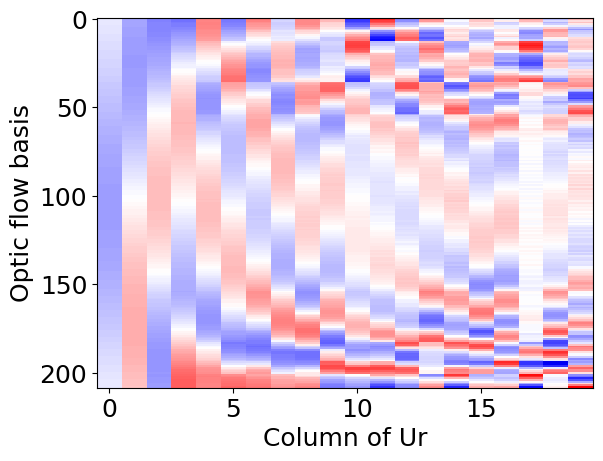

In [89]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(Ur, interpolation='nearest', cmap='seismic', vmin=-0.5, vmax=0.5)
ax.set_aspect('auto')

ax.set_xlabel('Column of Ur')
ax.set_ylabel('Optic flow basis')

### Example of compression and reconstruction

Here we compress and reconstruct a single snap shot of optic flow from the training set. 

In [90]:
# Extract one snap shot of optic flow
y = Omega[:,10:11]

Check the shapes of y and Ur. 

In [91]:
print(y.shape)
print(Ur.shape)

(209, 1)
(209, 20)


To project the original data into the reduced order basis we need to transpose $U_r$. 

In [92]:
# Project the snap shot into the reduced order basis
y_reduc = Ur.T@y

Visualize the reduced order projection. 

Text(0, 0.5, 'Basis coefficient value')

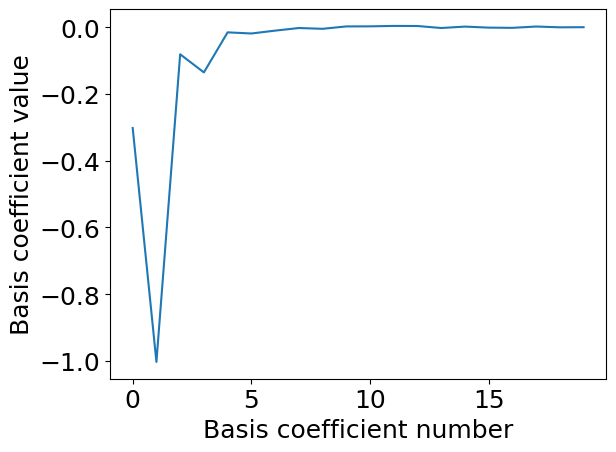

In [93]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(y_reduc)
ax.set_xlabel('Basis coefficient number')
ax.set_ylabel('Basis coefficient value')

Reconstruct t5he full dimension from the compressed value for y and compare to the original signal. Notice how we have captured the key features of the original signal, but with far fewer values. We also did this using a linear transformation. 

In [94]:
# Reconstruct the full dimension from the compressed y
y_recon = Ur@y_reduc

Text(0, 0.5, 'Optic flow value')

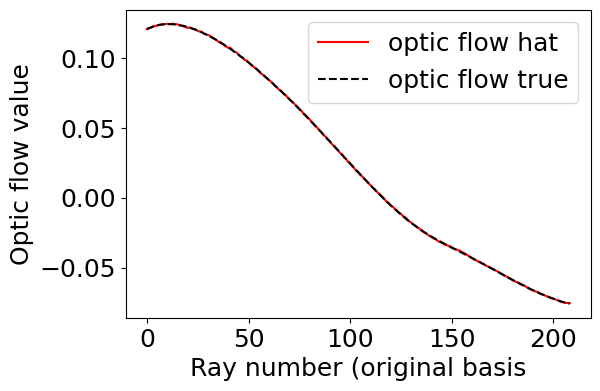

In [95]:
plot_tme(np.arange(0, len(y), 1), y, None, y_recon, label_var='optic flow')

plt.xlabel('Ray number (original basis')
plt.ylabel('Optic flow value')

# Use the SVD compressor on test data

Now we see if our SVD compression generalizes to other trajectories that were not in the original test set. 

In [96]:
trajec_optic_flow = test_set[0]

In [97]:
# Load, compress, and reconstruct the test data
test_Omega = trajec_optic_flow.values.T
test_data_reduc = Ur.T@test_Omega
test_data_recon = Ur@test_data_reduc

Text(0.5, 0, 'Time, pts')

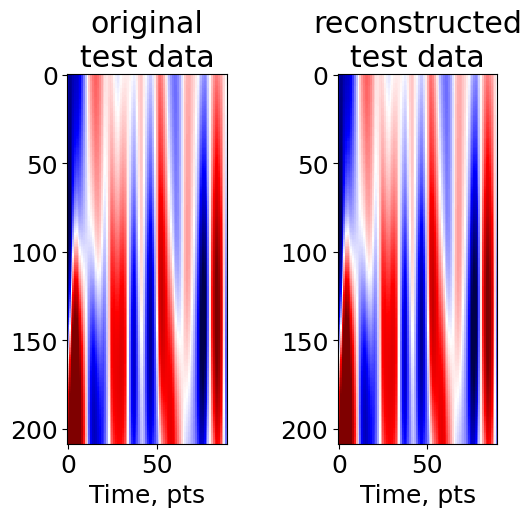

In [98]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title('original\ntest data')
ax1.imshow(test_Omega, interpolation='nearest', vmin=-0.5, vmax=0.5, cmap='seismic')
ax1.set_xlabel('Time, pts')

ax2.set_title('reconstructed\ntest data')
ax2.imshow(test_data_recon, interpolation='nearest', vmin=-0.5, vmax=0.5, cmap='seismic')
ax2.set_xlabel('Time, pts')

# Exercises

1. Change the truncation rank. How small can you make it and still get a good reconstruction?
2. Construct an optic flow time series that is very different from the patterns in the training set. Does the SVD compression generalize? You can do this one of two ways:
   * Manually construct the optic flow arbitrarily without regard for the terrain or drone movement
   * Construct a new drone trajectory, terrain, and determine the corresponding optic flow. See below for tips.

# Tips for constructing a novel trajectory, terrain, and optic flow time series

The yellow highlighted sections are ones where you need to make a change to generate a novel trajectory and terrain profile.

### 1. Create a new trajectory

This first section needs no adjustment.

In [72]:
# Planar drone dynamics and measurements
f = planar_drone.F(k=1).f
h = planar_drone.H('h_camera_imu', k=1).h

# Time step
dt = 0.1

# Set up the simulator
state_names = ['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot']
input_names = ['j1', 'j2']
measurement_names = h(None, None, return_measurement_names=True)

simulator = pybounds.Simulator(f, h, dt=dt, state_names=state_names,
                               input_names=input_names, measurement_names=measurement_names, mpc_horizon=10)


 <mark>This is the part you should consider changing</mark> to make the trajectory do something new and interesting. Note that the path it takes will still be limited by its dynamics -- the MPC will take care of that. 

In [73]:
# First define the set-point(s) to follow
tsim = np.arange(0, 5.0, step=dt)
NA = np.zeros_like(tsim)
setpoint = {'theta': NA,
            'theta_dot': NA,
            'x': 1.0*np.cos(2*np.pi*tsim*0.3),  # <<<< Do something interesting here
            'x_dot': NA,
            'z': 0.3*np.sin(2*np.pi*tsim*0.2)+0.5, # <<<<<< Do something interesting here
            'z_dot': NA,
           }

Run the MPC to make the drone follow the setpoints. Needs no adjustment.

In [74]:
# Update the simulator set-point
simulator.update_dict(setpoint, name='setpoint')

# Define MPC cost function: penalize the squared error between the setpoint for g and the true g
cost_x = (simulator.model.x['x'] - simulator.model.tvp['x_set']) ** 2
cost_z = (simulator.model.x['z'] - simulator.model.tvp['z_set']) ** 2
cost = cost_x + cost_z

# Set cost function
simulator.mpc.set_objective(mterm=cost, lterm=cost)  # objective function

# Set input penalty: make this small for accurate state tracking
simulator.mpc.set_rterm(j1=1e-4, j2=1e-4)

# Set some bounds
simulator.mpc.bounds['lower', '_x', 'theta'] = -np.pi/4
simulator.mpc.bounds['upper', '_x', 'theta'] = np.pi/4
simulator.mpc.bounds['lower', '_x', 'z'] = 0.0
simulator.mpc.bounds['lower', '_u', 'j2'] = 0.0

# Run simulation using MPC
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, u=None, mpc=True, return_full_output=True)

Repackage the simulation results into a trajectory dataframe. Needs no adjustment. 

In [75]:
t_sim_df = pd.DataFrame({'time': t_sim})
x_sim_df = pd.DataFrame(x_sim)
u_sim_df = pd.DataFrame(u_sim)
y_sim_df = pd.DataFrame(y_sim)

new_names = {key: 'sensor_' + key for key in y_sim_df}
y_sim_df = y_sim_df.rename(columns=new_names)

objid = pd.DataFrame({'objid': (1*np.ones_like(tsim)).astype(int)})

df = pd.concat([t_sim_df, objid, x_sim_df, u_sim_df, y_sim_df], axis=1)

trim_indices = 5
test_trajec = df.iloc[trim_indices:-trim_indices]

### 2. Create a new terrain profile

Get a terrain object, and <mark>replace the terrain attribute with something completely different from the training set</mark>. 

Hint: you can get a sense of the training set terrain by visualizing a bunch of random seeds of the terrain object. 

In [76]:
terrain = terrain_and_optic_flow_utility.Terrain(seed=1)

# terrain.terrain defines the elevation profile, you can change in this in place. 
# If you do, then you need to run this function so that subsequent functions that use the terrain object have the up-to-date profile.
terrain.__update_curve_points__()

Adjust the trajectory altitude and visualize your terrain and drone trajectory. 

../Utility/terrain_and_optic_flow_utility.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trajec.z += altitude_adjustment
../Utility/terrain_and_optic_flow_utility.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trajec['ventral_altitude'] = trajec.z.values - ventral_elevation_array


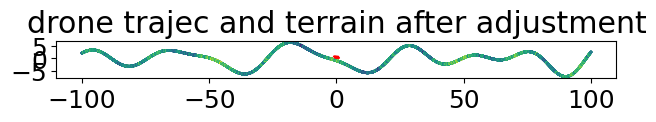

In [77]:
# adjust trajectory height
test_trajec_adj = terrain_and_optic_flow_utility.adjust_trajec_altitude(test_trajec, terrain, plot=True)

### 3. Calculate the optic flow over time for this trajectory and visualize it. 

In [78]:
result = terrain_and_optic_flow_utility.get_imgs_and_analytic_optic_flows(test_trajec_adj, terrain)
imgs, analytic_optic_flows, ray_distances = result

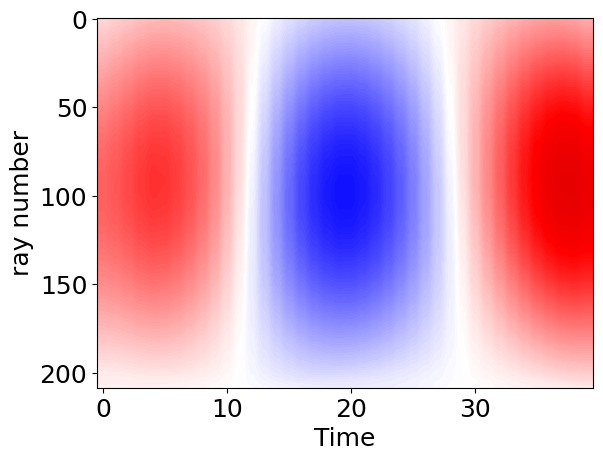

In [80]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(analytic_optic_flows, vmin=-3, vmax=3, cmap='seismic')
ax.set_ylabel('ray number')
ax.set_xlabel('Time')

ax.set_aspect('auto')

### 4. Compress / Reconstruct the optic flow time series

<mark>Use the same SVD compressor as was trained on the training data. How does the reconstruction compare to the true value? How different is your trajectory and elevation profile from the training set?</mark>